In [1]:
import random
import argparse
import os
from tqdm import tqdm
from termcolor import colored
import numpy as np
import torch
from torchsummary import summary
import torchvision.transforms as transforms
from torchvision.datasets import Omniglot
import wandb
from model import *
from sampler import PrototypeSampler

In [2]:
from easydict import EasyDict
args = EasyDict(dict(num_support_tr=5, learning_rate=0.0001, lr_scheduler_step=20, lr_scheduler_gamma=0.5))
model = Proto((1,105,105), 5, args, torch.device("cpu"))

In [3]:
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.92206, std=0.08426)
])
data = Omniglot(root="C:\\Users\\abdul\\Projects\\Self-Supervised-Learning\\Datasets\\", background=False, download=True, transform=val_transform)

Files already downloaded and verified


In [4]:
data

Dataset Omniglot
    Number of datapoints: 13180
    Root location: C:\Users\abdul\Projects\Self-Supervised-Learning\Datasets\omniglot-py
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.92206, std=0.08426)
           )

In [5]:
args.num_support_val = 5
args.num_query_val = 5
args.classes_per_it_val = 5
args.iterations = 100
targets = torch.tensor(list(map(lambda a: a[1], data._flat_character_images)))
sampler = PrototypeSampler(targets, args.num_support_val, args.num_query_val, args.classes_per_it_val, args.iterations)
loader = torch.utils.data.DataLoader(data, batch_sampler=sampler, num_workers=1, pin_memory=True)

In [6]:
len(data)

13180

In [7]:
sample = next(iter(loader))

In [8]:
x,y = sample
x.shape, y.shape

(torch.Size([50, 1, 105, 105]), torch.Size([50]))

In [9]:
model.load_prototype("C:\\Users\\abdul\\Projects\\Self-Supervised-Learning\\PrototypicalNet_MNIST\\output\\prototype_epoch_90.pth")


In [11]:
x_proto = model.cpu().prototyper(x)

In [12]:
x_proto.shape

torch.Size([50, 32])

In [13]:
torch.unique(y)

tensor([163, 355, 441, 569, 614])

In [15]:
classes = torch.unique(y)
support_idxs = list(map(lambda c: y.eq(c).nonzero()[:args.num_support_val].squeeze(1), classes))

prototypes = torch.stack([x_proto[idx_list].mean(0) for idx_list in support_idxs])

In [16]:
prototypes.shape

torch.Size([5, 32])

In [18]:
cat_feats = torch.cat([x_proto, prototypes])
cat_feats.shape

torch.Size([55, 32])

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [20]:
x_embed = TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(cat_feats.detach().numpy())

C:\Users\abdul\Projects\projects\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [21]:
x_embed.shape

(55, 2)

In [22]:
colors = ['blue','orange','green','red', 'purple']

In [23]:
target_inds = torch.zeros_like(y)

In [24]:
for i,c in enumerate(classes, 1):
    target_inds[y.eq(c)] = i

In [25]:
target_inds

tensor([2, 5, 2, 5, 1, 4, 2, 5, 1, 3, 5, 5, 4, 1, 1, 4, 2, 1, 1, 2, 5, 3, 5, 4,
        4, 2, 4, 2, 3, 3, 5, 4, 3, 1, 3, 1, 4, 1, 3, 3, 3, 5, 1, 4, 2, 5, 2, 3,
        4, 2])

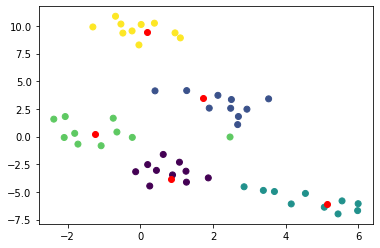

In [26]:
plt.scatter(x_embed[:50,0], x_embed[:50,1], c=target_inds)
plt.scatter(x_embed[50:,0], x_embed[50:,1], c="red")
plt.show()